In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Embedding, GlobalMaxPooling1D, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
from transformers import BertTokenizer, TFBertModel
import tensorflow as tf


In [2]:
# Load the dataset
file_path = '/content/cyberbullying_tweets.csv'
df = pd.read_csv(file_path)

# Remove duplicate tweets
df = df.drop_duplicates(subset=['tweet_text'])

# Convert labels to binary (1 for cyberbullying, 0 for not_cyberbullying)
df['cyberbullying_type'] = df['cyberbullying_type'].apply(lambda x: 1 if x != 'not_cyberbullying' else 0)


In [3]:
# Balance the dataset by undersampling the majority class
cyberbullying = df[df['cyberbullying_type'] == 1]
not_cyberbullying = df[df['cyberbullying_type'] == 0]

# Undersample the majority class
cyberbullying_undersampled = cyberbullying.sample(len(not_cyberbullying), random_state=42)

# Combine the undersampled data and shuffle
balanced_df = pd.concat([cyberbullying_undersampled, not_cyberbullying]).sample(frac=1, random_state=42)


In [4]:
# Tokenize tweets into lists of words
balanced_df['tweet_text'] = balanced_df['tweet_text'].apply(lambda x: x.split())

# Train a Word2Vec model
word2vec_model = Word2Vec(
    sentences=balanced_df['tweet_text'],
    vector_size=50,
    window=5,
    min_count=1,
    workers=4
)


In [5]:
# Function to get mean Word2Vec embeddings for a tweet
def get_w2v_embeddings(text):
    return np.mean([word2vec_model.wv[word] for word in text if word in word2vec_model.wv], axis=0) if len(text) > 0 else np.zeros(word2vec_model.vector_size)

# Generate embeddings for all tweets
balanced_df['w2v_embeddings'] = balanced_df['tweet_text'].apply(get_w2v_embeddings)


In [6]:
from sklearn.decomposition import PCA

# Reduce dimensions of Word2Vec embeddings to 20 features
X = PCA(n_components=20).fit_transform(np.vstack(balanced_df['w2v_embeddings'].values))
y = balanced_df['cyberbullying_type']


In [7]:
# Split data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [8]:
# Train an SVM classifier
svm = SVC(kernel='linear', probability=True)
svm.fit(X_train, y_train)

# Make predictions
svm_preds = svm.predict(X_test)

# Evaluate SVM
print("SVM Classification Report:\n", classification_report(y_test, svm_preds))


SVM Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.75      0.76      1583
           1       0.76      0.77      0.76      1592

    accuracy                           0.76      3175
   macro avg       0.76      0.76      0.76      3175
weighted avg       0.76      0.76      0.76      3175



SVM Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.75      0.76      1583
           1       0.76      0.77      0.76      1592

    accuracy                           0.76      3175
   macro avg       0.76      0.76      0.76      3175
weighted avg       0.76      0.76      0.76      3175



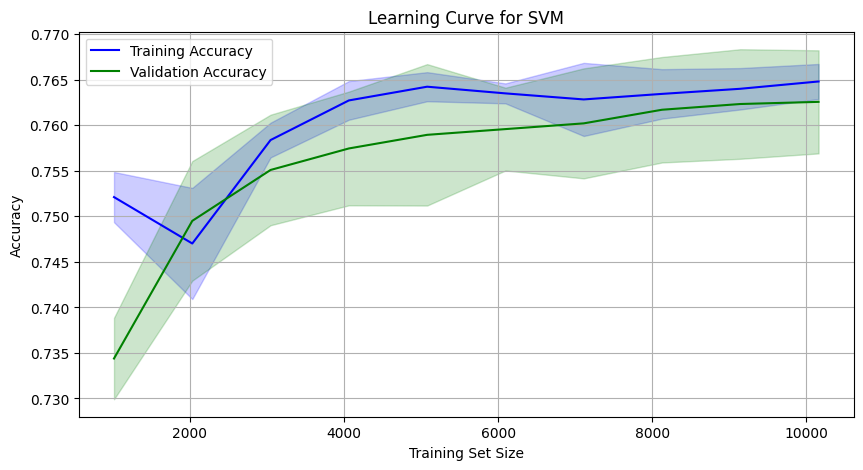

In [27]:
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.model_selection import learning_curve
import numpy as np

# Train an SVM classifier
svm = SVC(kernel='linear', probability=True)
svm.fit(X_train, y_train)

# Make predictions
svm_preds = svm.predict(X_test)

# Evaluate SVM
print("SVM Classification Report:\n", classification_report(y_test, svm_preds))

# --- Learning Curve for SVM ---
# Use learning_curve function to calculate training and test scores at various training set sizes
train_sizes, train_scores, test_scores = learning_curve(
    svm, X_train, y_train, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
)

# Calculate the mean and standard deviation for train and test scores
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot learning curve for SVM
plt.figure(figsize=(10, 5))
plt.plot(train_sizes, train_mean, label='Training Accuracy', color='blue')
plt.plot(train_sizes, test_mean, label='Validation Accuracy', color='green')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color='blue')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.2, color='green')

plt.title('Learning Curve for SVM')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid()
plt.show()


In [9]:
# Build a CNN model
cnn_model = Sequential([
    Embedding(
        input_dim=word2vec_model.wv.vectors.shape[0],
        output_dim=50,
        weights=[word2vec_model.wv.vectors],
        trainable=False
    ),
    Conv1D(filters=32, kernel_size=3, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
cnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train CNN
cnn_history = cnn_model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/5
397/397 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - accuracy: 0.5934 - loss: 0.6682 - val_accuracy: 0.6438 - val_loss: 0.6199
Epoch 2/5
397/397 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.6442 - loss: 0.6216 - val_accuracy: 0.6450 - val_loss: 0.6150
Epoch 3/5
397/397 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6400 - loss: 0.6132 - val_accuracy: 0.6214 - val_loss: 0.6116
Epoch 4/5
397/397 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6368 - loss: 0.6072 - val_accuracy: 0.6447 - val_loss: 0.6114
Epoch 5/5
397/397 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6352 - loss: 0.6111 - val_accuracy: 0.6447 - val_loss: 0.6108


In [10]:
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel
import numpy as np

# Load BERT tokenizer and model (use GPU by default if available)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

# Function to process a batch of texts
def get_bert_embeddings_batch(batch):
    # Move tensors to GPU (this should be automatic with TensorFlow GPU)
    inputs = tokenizer(batch, return_tensors='tf', padding=True, truncation=True, max_length=32)
    outputs = bert_model(inputs)
    return outputs.last_hidden_state[:, 0, :].numpy()  # Use the [CLS] token embedding

# Function to get embeddings in batches
def get_bert_embeddings_in_batches(texts, batch_size=64):
    embeddings = []
    # Iterate through text in batches
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i + batch_size]
        embeddings_batch = get_bert_embeddings_batch(batch)
        embeddings.append(embeddings_batch)
        print(f"Processed {min(i + batch_size, len(texts))}/{len(texts)} texts...")  # Monitor progress
    return np.vstack(embeddings)

# Preprocess texts into a list of strings (assuming the 'tweet_text' column is tokenized into a list of words)
texts = balanced_df['tweet_text'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x).tolist()

# Check if GPU is available
if tf.config.experimental.list_physical_devices('GPU'):
    print("GPU is available, using GPU for computation.")
else:
    print("GPU is not available, using CPU.")

# Get BERT embeddings
bert_embeddings = get_bert_embeddings_in_batches(texts)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

GPU is available, using GPU for computation.
Processed 64/15874 texts...
Processed 128/15874 texts...
Processed 192/15874 texts...
Processed 256/15874 texts...
Processed 320/15874 texts...
Processed 384/15874 texts...
Processed 448/15874 texts...
Processed 512/15874 texts...
Processed 576/15874 texts...
Processed 640/15874 texts...
Processed 704/15874 texts...
Processed 768/15874 texts...
Processed 832/15874 texts...
Processed 896/15874 texts...
Processed 960/15874 texts...
Processed 1024/15874 texts...
Processed 1088/15874 texts...
Processed 1152/15874 texts...
Processed 1216/15874 texts...
Processed 1280/15874 texts...
Processed 1344/15874 texts...
Processed 1408/15874 texts...
Processed 1472/15874 texts...
Processed 1536/15874 texts...
Processed 1600/15874 texts...
Processed 1664/15874 texts...
Processed 1728/15874 texts...
Processed 1792/15874 texts...
Processed 1856/15874 texts...
Processed 1920/15874 texts...
Processed 1984/15874 texts...
Processed 2048/15874 texts...
Processed 2

In [11]:
X_bert = bert_embeddings
X_train_bert, X_test_bert, y_train_bert, y_test_bert = train_test_split(X_bert, y, test_size=0.2, random_state=42)


In [12]:
lstm_model = Sequential([
    LSTM(64, input_shape=(1, 768), return_sequences=False),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
lstm_history = lstm_model.fit(X_train_bert.reshape(-1, 1, 768), y_train_bert, epochs=5, batch_size=32, validation_data=(X_test_bert.reshape(-1, 1, 768), y_test_bert))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
397/397 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.7811 - loss: 0.4646 - val_accuracy: 0.8513 - val_loss: 0.3519
Epoch 2/5
397/397 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8456 - loss: 0.3530 - val_accuracy: 0.8624 - val_loss: 0.3348
Epoch 3/5
397/397 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8580 - loss: 0.3320 - val_accuracy: 0.8627 - val_loss: 0.3281
Epoch 4/5
397/397 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8588 - loss: 0.3220 - val_accuracy: 0.8665 - val_loss: 0.3181
Epoch 5/5
397/397 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8671 - loss: 0.3082 - val_accuracy: 0.8661 - val_loss: 0.3159


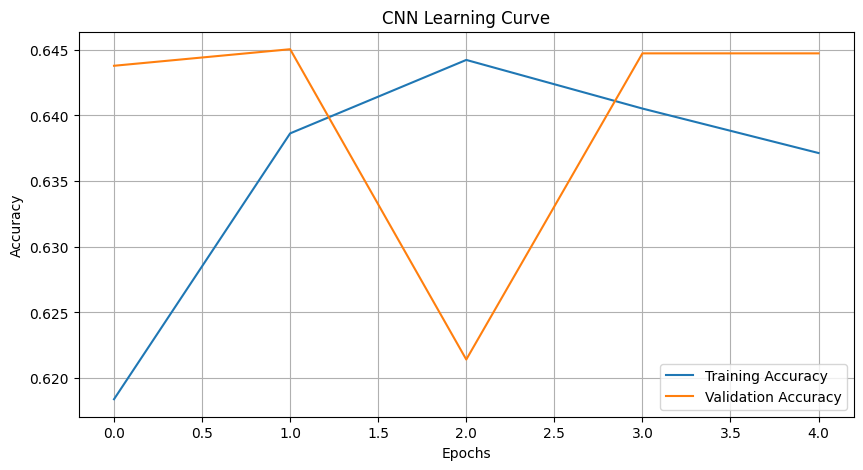

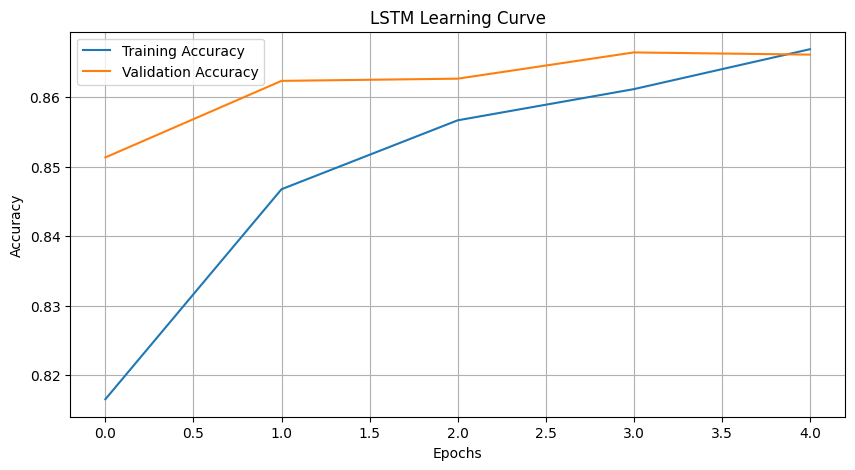

In [17]:
def plot_learning_curve(history, model_name):
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} Learning Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()
    plt.show()

plot_learning_curve(cnn_history, 'CNN')
plot_learning_curve(lstm_history, 'LSTM')




In [18]:
print("SVM Classification Report:\n", classification_report(y_test, svm_preds))
print("CNN Classification Report:\n", classification_report(y_test, (cnn_model.predict(X_test) > 0.5).astype("int32")))
print("LSTM Classification Report:\n", classification_report(y_test_bert, (lstm_model.predict(X_test_bert.reshape(-1, 1, 768)) > 0.5).astype("int32")))


SVM Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.75      0.76      1583
           1       0.76      0.77      0.76      1592

    accuracy                           0.76      3175
   macro avg       0.76      0.76      0.76      3175
weighted avg       0.76      0.76      0.76      3175

100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
CNN Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.80      0.69      1583
           1       0.71      0.49      0.58      1592

    accuracy                           0.64      3175
   macro avg       0.66      0.65      0.64      3175
weighted avg       0.66      0.64      0.64      3175

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
LSTM Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.88      0.87      1583
           1       0.87      0.86      0.87      1592

    accuracy   

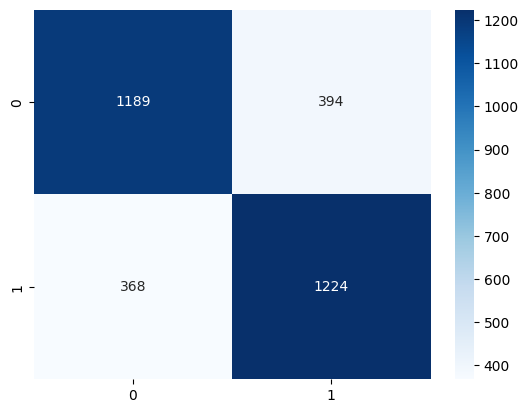

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


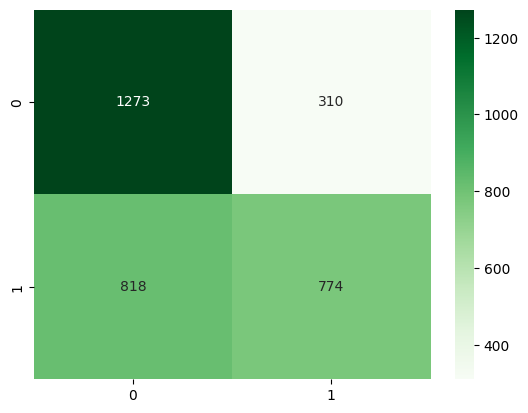

100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


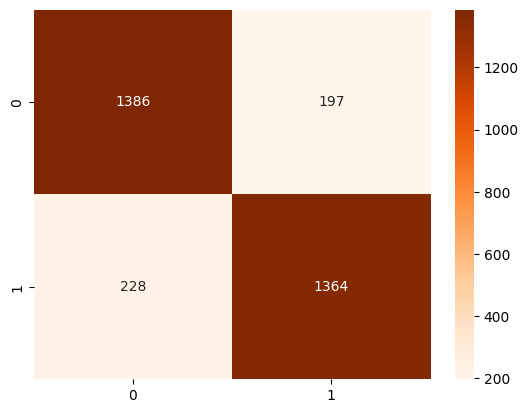

In [20]:
!pip install seaborn
import seaborn as sns # Import seaborn and assign it to the alias 'sns'
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# ... your existing code ...

sns.heatmap(confusion_matrix(y_test, svm_preds), annot=True, fmt='d', cmap='Blues')
plt.show()

sns.heatmap(confusion_matrix(y_test, (cnn_model.predict(X_test) > 0.5).astype("int32")), annot=True, fmt='d', cmap='Greens')
plt.show()

sns.heatmap(confusion_matrix(y_test_bert, (lstm_model.predict(X_test_bert.reshape(-1, 1, 768)) > 0.5).astype("int32")), annot=True, fmt='d', cmap='Oranges')
plt.show()

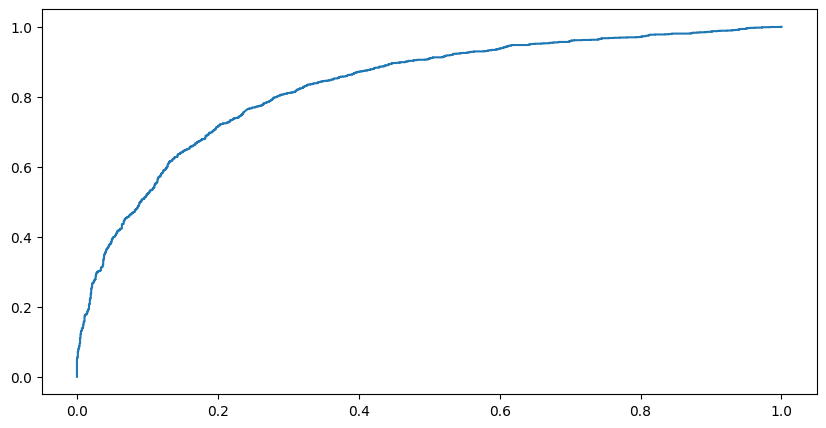

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


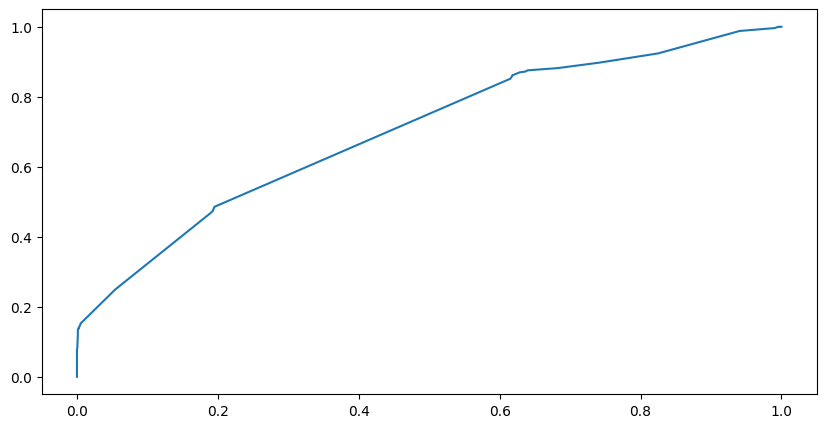

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


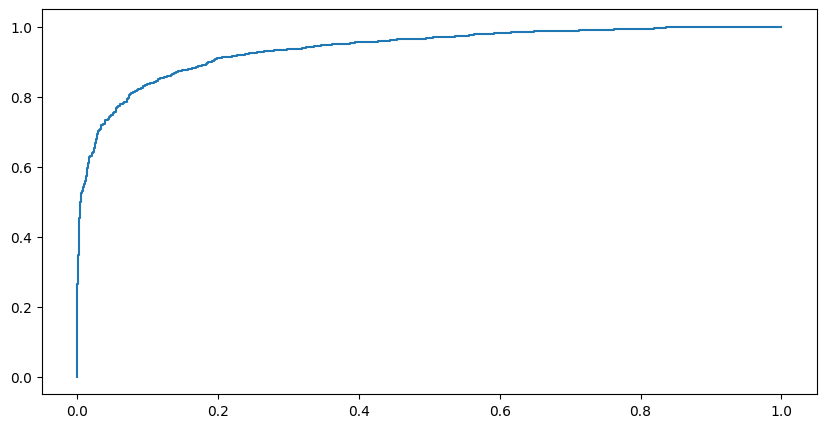

In [22]:
from sklearn.metrics import roc_curve, auc # Import roc_curve and auc from sklearn.metrics

def plot_roc_curve(y_test, probs, model_name):
    fpr, tpr, _ = roc_curve(y_test, probs)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(10, 5))
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')
    plt.show()

plot_roc_curve(y_test, svm.predict_proba(X_test)[:, 1], "SVM")
plot_roc_curve(y_test, cnn_model.predict(X_test), "CNN")
plot_roc_curve(y_test_bert, lstm_model.predict(X_test_bert.reshape(-1, 1, 768)), "LSTM")

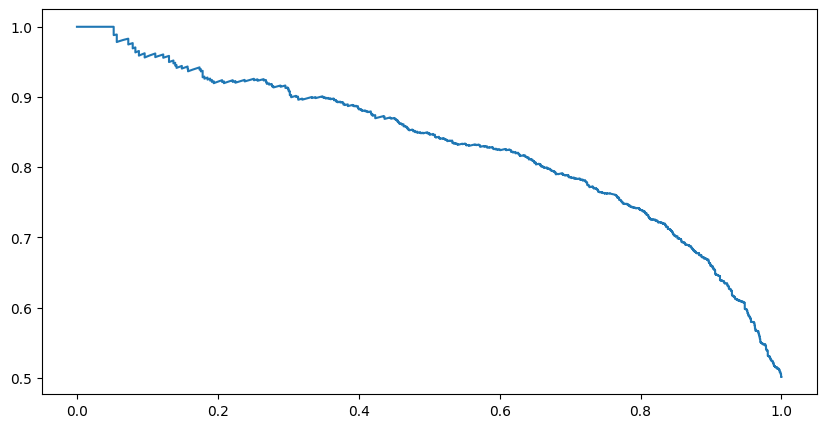

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


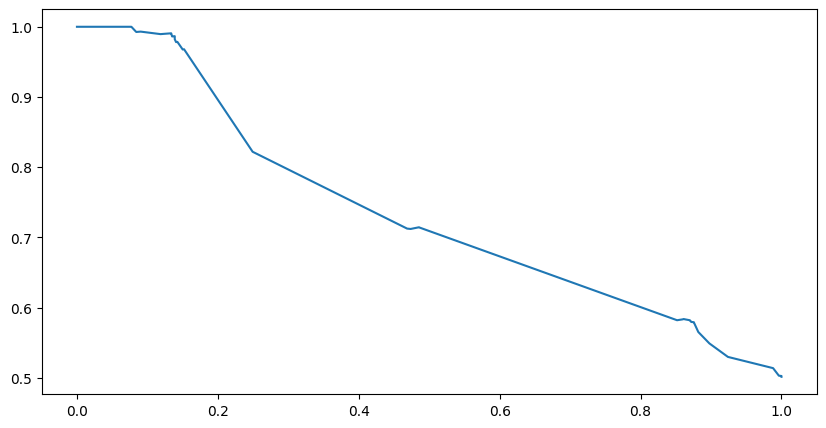

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


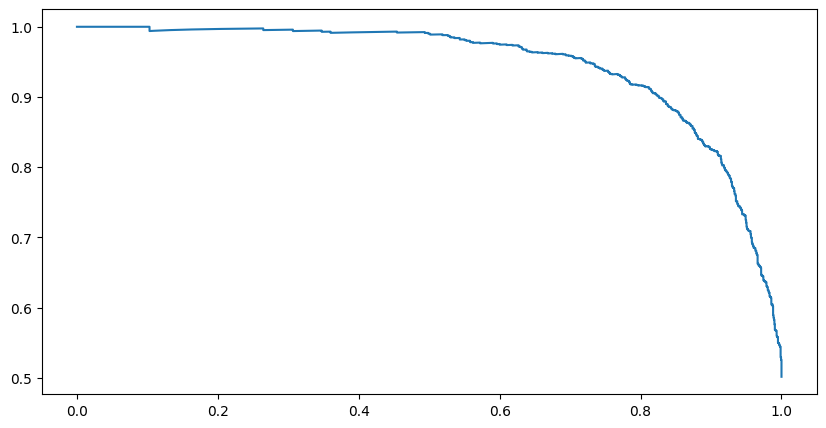

In [25]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve # Import precision_recall_curve

def plot_precision_recall_curve(y_test, probs, model_name):
    precision, recall, _ = precision_recall_curve(y_test, probs)
    plt.figure(figsize=(10, 5))
    plt.plot(recall, precision, label=model_name)
    plt.show()

plot_precision_recall_curve(y_test, svm.predict_proba(X_test)[:, 1], "SVM")
plot_precision_recall_curve(y_test, cnn_model.predict(X_test), "CNN")
plot_precision_recall_curve(y_test_bert, lstm_model.predict(X_test_bert.reshape(-1, 1, 768)), "LSTM")

In [31]:
from sklearn.model_selection import cross_val_score, StratifiedKFold # Import cross_val_score and StratifiedKFold from sklearn.model_selection
import numpy as np
from scipy.stats import f_oneway
import scipy.stats as stats  # Import the scipy.stats module

# Cross-validation results (you should already have these from previous code)
svm_accuracies = cross_val_score(svm, X_train, y_train, cv=5, scoring='accuracy')
cnn_accuracies = []
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for train_index, val_index in kfold.split(X_train, y_train):
    cnn_model.fit(X_train[train_index], y_train.iloc[train_index], epochs=3, batch_size=32, verbose=0)
    cnn_accuracy = cnn_model.evaluate(X_train[val_index], y_train.iloc[val_index], verbose=0)[1]
    cnn_accuracies.append(cnn_accuracy)

lstm_accuracies = []
for train_index, val_index in kfold.split(X_train_bert, y_train):
    lstm_model.fit(X_train_bert[train_index].reshape(-1, 1, 768), y_train.iloc[train_index], epochs=3, batch_size=32, verbose=0)
    lstm_accuracy = lstm_model.evaluate(X_train_bert[val_index].reshape(-1, 1, 768), y_train.iloc[val_index], verbose=0)[1]
    lstm_accuracies.append(lstm_accuracy)

# Perform ANOVA test with the collected accuracies from SVM, CNN, and LSTM
anova_result = stats.f_oneway(svm_accuracies, cnn_accuracies, lstm_accuracies)

# Print the ANOVA test results
print("ANOVA Test Results:")
print("F-statistic:", anova_result.statistic)
print("p-value:", anova_result.pvalue)

ANOVA Test Results:
F-statistic: 469.07032726787526
p-value: 4.058448786883205e-12
